In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== config ==========
FILE_2011 = r"C:\\StudySources\\Master\\ERP\\Datasets\\2011\\combined_output.csv"   
FILE_2021 = r"C:\\StudySources\\Master\\ERP\\Datasets\\2021\\combined_output.csv"   
OUT_DIR   = "./figures"
os.makedirs(OUT_DIR, exist_ok=True)

# set canonical methods
CANONICAL_METHODS = [
    "Work mainly at or from home",
    "Underground, metro, light rail, tram",
    "Train",
    "Bus, minibus or coach",
    "Taxi",
    "Motorcycle, scooter or moped",
    "Driving a car or van",
    "Passenger in a car or van",
    "Bicycle",
    "On foot",
    "Other method of travel to work",
]

# set possible explainers
POSSIBLE_EXPLAINERS = [
    "Total population 16+",
    "Aged 16 to 24 years",
    "Aged 25 to 34 years",
    "Aged 35 to 49 years",
    "Aged 50 to 64 years",
    "Aged 65 years and over",
    "Total car van"
]

# ========== Tool Functions ==========
def normalise_cols(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    df.columns = [re.sub(r"\s+", " ", c.strip()).lower() for c in df.columns]
    return df

def best_match_col(df, candidates):
    """
    For each canonical mode name, find the "most similar" column in df.
    Uses loose matching: exact lowercase match / compacted (remove punctuation/space) match / keyword inclusion.
    """
    colmap = {}
    dfcols = list(df.columns)
    for target in candidates:
        t = target.lower().strip()
        t_compact = re.sub(r"[^a-z0-9]+", "", t)

        # 1) Exact match
        for c in dfcols:
            if c == t:
                colmap[target] = c
                break
        else:
            # 2) Compacted match (remove non-alphanumeric)
            for c in dfcols:
                c_compact = re.sub(r"[^a-z0-9]+", "", c)
                if c_compact == t_compact:
                    colmap[target] = c
                    break
            else:
                # 3) Keyword inclusion (e.g. "work mainly at or from home" may have slight variations)
                key_tokens = [w for w in re.split(r"[^a-z0-9]+", t) if w]
                best = None
                best_hits = -1
                for c in dfcols:
                    hits = sum(1 for w in key_tokens if w and w in c)
                    if hits > best_hits:
                        best_hits = hits
                        best = c
                # At least 2 keyword hits to be considered
                if best_hits >= 2:
                    colmap[target] = best
                else:
                    colmap[target] = None
    return colmap

def extract_la_from_lsoa(name: str) -> str:
    """
    Extract LA (e.g. 'Bolton') from strings like 'Bolton 005A'.
    If not present, return empty string.
    """
    if not isinstance(name, str):
        return ""
    return name.split()[0]

def safe_sum(df, col):
    return float(pd.to_numeric(df[col], errors="coerce").fillna(0).sum())

def percent(x):
    return 100.0 * x

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

# ========== Read and unify column names ==========
raw11 = pd.read_csv(FILE_2011, low_memory=False)
raw21 = pd.read_csv(FILE_2021, low_memory=False)

df11 = normalise_cols(raw11)
df21 = normalise_cols(raw21)

# Identify LSOA name column (e.g. '2021 super output area - lower layer')
# Use a loose search
def guess_lsoa_col(df):
    for c in df.columns:
        if "super output area" in c and "lower" in c:
            return c
    # Alternative: column name contains lsoa
    for c in df.columns:
        if "lsoa" in c:
            return c
    return None

lsoa_col_11 = guess_lsoa_col(df11)
lsoa_col_21 = guess_lsoa_col(df21)

if lsoa_col_11 is None and lsoa_col_21 is None:
    print("Warning: LSOA name column not found, some area-based analysis will be skipped.")

# Build mode column mapping for both years
colmap11 = best_match_col(df11, CANONICAL_METHODS)
colmap21 = best_match_col(df21, CANONICAL_METHODS)

missing11 = [k for k, v in colmap11.items() if v is None]
missing21 = [k for k, v in colmap21.items() if v is None]
if missing11:
    print("2011 missing mode columns (could not match):", missing11)
if missing21:
    print("2021 missing mode columns (could not match):", missing21)

# ========== Calculate totals/shares ==========
tot11 = {}
tot21 = {}
for m in CANONICAL_METHODS:
    c11 = colmap11.get(m)
    c21 = colmap21.get(m)
    tot11[m] = safe_sum(df11, c11) if c11 else 0.0
    tot21[m] = safe_sum(df21, c21) if c21 else 0.0

s11 = pd.Series(tot11, name="2011")
s21 = pd.Series(tot21, name="2021")
totals = pd.concat([s11, s21], axis=1)

totals["2011_share(%)"] = percent(totals["2011"] / totals["2011"].sum())
totals["2021_share(%)"] = percent(totals["2021"] / totals["2021"].sum())
totals["pp_change(2021-2011)"] = totals["2021_share(%)"] - totals["2011_share(%)"]
totals.to_csv(os.path.join(OUT_DIR, "mode_totals_shares_changes.csv"))
print("Exported: figures/mode_totals_shares_changes.csv")

# ========== Figure 1: Stacked percentage comparison for both years ==========
fig, ax = plt.subplots(figsize=(9, 5))
shares11 = totals["2011_share(%)"].values
shares21 = totals["2021_share(%)"].values
labels   = totals.index.tolist()

# Draw two side-by-side stacked bars (2011 and 2021)
def stacked_bar(ax, shares, x, label_prefix):
    bottom = 0
    for i, v in enumerate(shares):
        ax.bar(x, v, bottom=bottom, label=labels[i] if label_prefix=="2011" else None)
        bottom += v

stacked_bar(ax, shares11, x=0, label_prefix="2011")
stacked_bar(ax, shares21, x=1, label_prefix="2021")

ax.set_xticks([0,1]); ax.set_xticklabels(["2011","2021"])
ax.set_ylabel("Share (%)")
ax.set_title("Mode Share (Stacked %) — 2011 vs 2021")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Mode", fontsize=8)
savefig(os.path.join(OUT_DIR, "01_mode_share_stacked_2011_vs_2021.png"))

# ========== Figure 2: Percentage point change for each mode ==========
fig, ax = plt.subplots(figsize=(9, 5))
chg = totals["pp_change(2021-2011)"].sort_values()
ax.barh(chg.index, chg.values)
ax.axvline(0, ls="--", lw=1, color="k")
ax.set_xlabel("Percentage points")
ax.set_title("Change in Mode Share (pp): 2021 - 2011")
savefig(os.path.join(OUT_DIR, "02_mode_share_pp_change.png"))

# ========== Area (LA) level comparison ==========
def attach_la(df, lsoa_col):
    if lsoa_col is None or lsoa_col not in df.columns:
        return df.assign(_la="")
    return df.assign(_la=df[lsoa_col].apply(extract_la_from_lsoa))

df11_la = attach_la(df11, lsoa_col_11)
df21_la = attach_la(df21, lsoa_col_21)

# Build mode share for each LA (sum of each mode / total for that LA)
def la_mode_share(df, colmap):
    cols = [c for c in colmap.values() if c is not None]
    tmp = df[cols + ["_la"]].copy()
    for c in cols:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce").fillna(0)
    g = tmp.groupby("_la")[cols].sum()
    g["__total__"] = g.sum(axis=1)
    share = g.div(g["__total__"].replace(0, np.nan), axis=0) * 100
    share = share.drop(columns="__total__", errors="ignore")
    # Map column names back to canonical mode names
    inv = {v:k for k,v in colmap.items() if v is not None}
    share = share.rename(columns=inv)
    return share

la_share_11 = la_mode_share(df11_la, colmap11)
la_share_21 = la_mode_share(df21_la, colmap21)

# Align LAs and columns for both years
common_las = la_share_11.index.intersection(la_share_21.index)
la_share_11 = la_share_11.loc[common_las, CANONICAL_METHODS].fillna(0)
la_share_21 = la_share_21.loc[common_las, CANONICAL_METHODS].fillna(0)
la_pp_change = la_share_21 - la_share_11  # Percentage point change for each LA and mode

# ========== Figure 3: LA-level change in sustainable/active/WFH modes (bar chart) ==========
SUSTAIN = [
    "Bus, minibus or coach",
    "Train",
    "Underground, metro, light rail, tram",
    "Bicycle",
    "On foot",
    "Work mainly at or from home"
]
la_sustain_chg = la_pp_change[SUSTAIN].sum(axis=1).sort_values(ascending=False)

top10 = la_sustain_chg.head(10)
bot10 = la_sustain_chg.tail(10)

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(top10.index, top10.values)
ax.set_title("Top 10 LAs by Sustainable/Active/WFH Share Increase (pp)")
ax.set_xlabel("pp change (sum of selected modes)")
savefig(os.path.join(OUT_DIR, "03_la_top10_sustain_active_wfh_change.png"))

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(bot10.index, bot10.values)
ax.set_title("Bottom 10 LAs by Sustainable/Active/WFH Share Increase (pp)")
ax.set_xlabel("pp change (sum of selected modes)")
savefig(os.path.join(OUT_DIR, "04_la_bottom10_sustain_active_wfh_change.png"))

# ========== Figure 4: WFH change only ==========
wfh = "Work mainly at or from home"
if wfh in la_pp_change.columns:
    wfh_chg = la_pp_change[wfh].sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.hist(wfh_chg.values, bins=30)
    ax.set_title("Distribution of WFH Share Change across LAs (pp)")
    ax.set_xlabel("pp change"); ax.set_ylabel("Number of LAs")
    savefig(os.path.join(OUT_DIR, "05_wfh_change_distribution.png"))

    # WFH Top/Bottom LAs
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(wfh_chg.head(15).index, wfh_chg.head(15).values)
    ax.set_title("Top 15 LAs by WFH Share Increase (pp)")
    ax.set_xlabel("pp change")
    savefig(os.path.join(OUT_DIR, "06_wfh_top15_increase.png"))

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(wfh_chg.tail(15).index, wfh_chg.tail(15).values)
    ax.set_title("Bottom 15 LAs by WFH Share Increase (pp)")
    ax.set_xlabel("pp change")
    savefig(os.path.join(OUT_DIR, "07_wfh_bottom15_increase.png"))

# ========== Figure 5: WFH vs structural factors (scatter plots) ==========
# Build LA-level age structure and car ownership proxy
def la_explainers(df):
    df = df.copy()
    # Reverse map original column names (not lowercased) for compatibility
    # Use lower mapping once
    lower_map = {c.lower(): c for c in raw11.columns}  # Only for finding column names
    # Try to find matching columns in current df (already lowercased)
    cols = []
    for key in POSSIBLE_EXPLAINERS:
        k = key.lower()
        # Find in df (already lowercased)
        found = None
        for c in df.columns:
            if k == c:
                found = c
                break
        if found is None:
            # Use keyword inclusion
            tokens = [w for w in re.split(r"[^a-z0-9]+", k) if w]
            best, hits = None, -1
            for c in df.columns:
                h = sum(1 for w in tokens if w and w in c)
                if h > hits:
                    hits, best = h, c
            if hits >= 2:
                found = best
        if found:
            cols.append(found)
    # Add _la
    if "_la" not in df.columns:
        return pd.DataFrame()
    keep = list(set(cols + ["_la"]))
    sub = df[keep].copy()
    for c in keep:
        if c != "_la":
            sub[c] = pd.to_numeric(sub[c], errors="coerce").fillna(0)
    g = sub.groupby("_la").sum(numeric_only=True)
    return g

la_exp_11 = la_explainers(df11_la)
la_exp_21 = la_explainers(df21_la)

# Align to common LAs
common = la_share_21.index.intersection(la_share_11.index)
la_exp_11 = la_exp_11.loc[common] if not la_exp_11.empty else pd.DataFrame(index=common)
la_exp_21 = la_exp_21.loc[common] if not la_exp_21.empty else pd.DataFrame(index=common)

if wfh in la_share_21.columns:
    y21 = la_share_21[wfh]  # 2021 WFH share
    # Scatter with age structure (2021) if available
    def try_scatter(xcol, xname):
        if xcol in la_exp_21.columns:
            fig, ax = plt.subplots(figsize=(6.5, 5))
            x = la_exp_21[xcol]
            ax.scatter(x, y21.loc[x.index])
            ax.set_xlabel(xname)
            ax.set_ylabel("WFH share in 2021 (%)")
            ax.set_title(f"WFH(2021) vs {xname}")
            # Sanitize filename: replace all non-alphanumeric characters with underscores
            safe_xname = re.sub(r'[^a-zA-Z0-9]+', '_', xname)
            savefig(os.path.join(OUT_DIR, f"08_wfh_vs_{safe_xname}.png"))

    # Try several common column names (lowercase)
    candidates = {
        "aged 25 to 34 years": "Aged 25–34 (count)",
        "aged 35 to 49 years": "Aged 35–49 (count)",
        "total car van": "Total car/van (proxy for ownership)",
        "aged 50 to 64 years": "Aged 50–64 (count)"
    }
    for k, v in candidates.items():
        try_scatter(k, v)

    # WFH change vs car ownership (2021)
    if "total car van" in la_exp_21.columns and wfh in la_pp_change.columns:
        fig, ax = plt.subplots(figsize=(6.5, 5))
        x = la_exp_21["total car van"]
        y = la_pp_change[wfh].loc[x.index]
        ax.scatter(x, y)
        ax.set_xlabel("Total car/van (2021)")
        ax.set_ylabel("WFH share change (pp, 2021-2011)")
        ax.set_title("WFH Change vs Car Ownership Proxy")
        savefig(os.path.join(OUT_DIR, "09_wfh_change_vs_car_total.png"))

# ========== Figure 6: Boxplots of LA-level mode shares (distribution change) ==========
for m in CANONICAL_METHODS:
    if m in la_share_11.columns and m in la_share_21.columns:
        two = pd.DataFrame({
            "2011": la_share_11[m],
            "2021": la_share_21[m]
        }).dropna()
        if len(two) > 0:
            fig, ax = plt.subplots(figsize=(6.5, 5))
            ax.boxplot([two["2011"], two["2021"]], labels=["2011","2021"])
            ax.set_ylabel("Share (%)")
            ax.set_title(f"{m} — LA Share Distribution")
            fname = f"10_box_{re.sub(r'[^a-z0-9]+','_',m.lower())}.png"
            savefig(os.path.join(OUT_DIR, fname))

print("All done ✅  Images saved to:", OUT_DIR)


已导出：figures/mode_totals_shares_changes.csv


C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1273315611.py:368: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([two["2011"], two["2021"]], labels=["2011","2021"])
C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1273315611.py:368: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([two["2011"], two["2021"]], labels=["2011","2021"])
C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1273315611.py:368: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([two["2011"], two["2021"]], labels=["2011","2021"])
C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1273315611.py:368: Matplo

全部完成 ✅  图片已保存到： ./figures


C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1273315611.py:368: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([two["2011"], two["2021"]], labels=["2011","2021"])


                                 2011      2021  2011_share(%)  2021_share(%)  \
Public Transit               189191.0  115439.0      14.975853       9.114099   
Active Transit               160210.0  123662.0      12.681795       9.763319   
Cars                         815388.0  661309.0      64.543931      52.211436   
Work mainly at or from home   98518.0  366188.0       7.798421      28.911146   

                             pp_change  
Public Transit               -5.861754  
Active Transit               -2.918476  
Cars                        -12.332495  
Work mainly at or from home  21.112725  


C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1875689089.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Rail Transit"] = df.get("Underground, metro, light rail, tram", 0) + df.get("Train", 0)
C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1875689089.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Active Transit"] = df.get("Motorcycle, scooter or moped", 0) + df.get("Bicycle", 0) + df.get("On foot", 0)
C:\Users\Harry.Xie\AppData\Local\Temp\ipykernel_34632\1875689089.py:22: PerformanceWarning: Dat

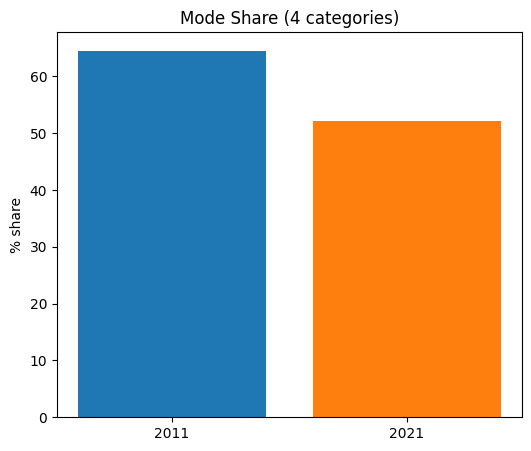

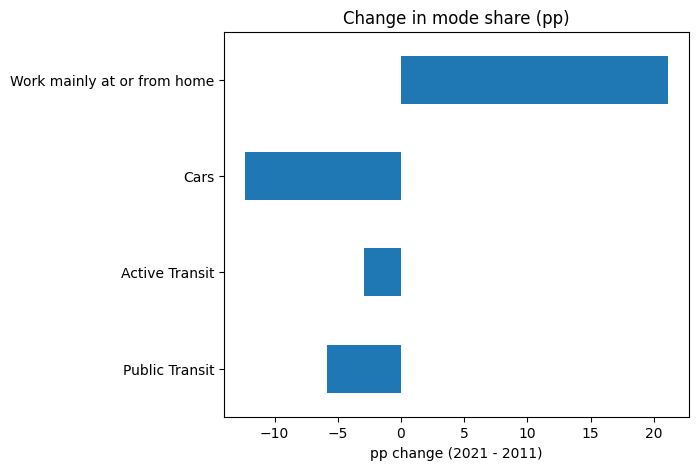

In [ ]:
import pandas as pd

# ========= Config ==========
FILE_2011 = r"C:\\StudySources\\Master\\ERP\\Datasets\\2011\\combined_output.csv"   # 改成你的2011数据路径
FILE_2021 = r"C:\\StudySources\\Master\\ERP\\Datasets\\2021\\combined_output.csv"   # 改成你的2021数据路径
OUT_DIR   = "./figures"
os.makedirs(OUT_DIR, exist_ok=True)

# ========== Load ==========
df11 = pd.read_csv(FILE_2011, low_memory=False)
df21 = pd.read_csv(FILE_2021, low_memory=False)

# ========== Merge ==========
def aggregate_modes(df):
    
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # create merged columns
    df["Rail Transit"] = df.get("Underground, metro, light rail, tram", 0) + df.get("Train", 0)
    df["Active Transit"] = df.get("Motorcycle, scooter or moped", 0) + df.get("Bicycle", 0) + df.get("On foot", 0)
    df["Public Transit"] = df["Rail Transit"] + df.get("Bus, minibus or coach", 0) + df.get("Taxi", 0)
    df["Cars"] = df.get("Driving a car or van", 0) + df.get("Passenger in a car or van", 0)

    return df

df11 = aggregate_modes(df11)
df21 = aggregate_modes(df21)

# keep only 4 main categories + WFH
transit_methods_general = [
    "Public Transit", 
    "Active Transit", 
    "Cars", 
    "Work mainly at or from home"
]

# ========== sum up ==========
tot11 = df11[transit_methods_general].sum()
tot21 = df21[transit_methods_general].sum()

comparison = pd.DataFrame({
    "2011": tot11,
    "2021": tot21
})
comparison["2011_share(%)"] = comparison["2011"] / comparison["2011"].sum() * 100
comparison["2021_share(%)"] = comparison["2021"] / comparison["2021"].sum() * 100
comparison["pp_change"] = comparison["2021_share(%)"] - comparison["2011_share(%)"]

print(comparison)

# ========== Visualization ==========
import matplotlib.pyplot as plt

# Stacked percentage
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(["2011"], comparison["2011_share(%)"], label="2011")
ax.bar(["2021"], comparison["2021_share(%)"], label="2021")
plt.title("Mode Share (4 categories)")
plt.ylabel("% share")
plt.show()

# Change bar chart
comparison["pp_change"].plot(kind="barh", figsize=(6,5), title="Change in mode share (pp)")
plt.xlabel("pp change (2021 - 2011)")
plt.show()


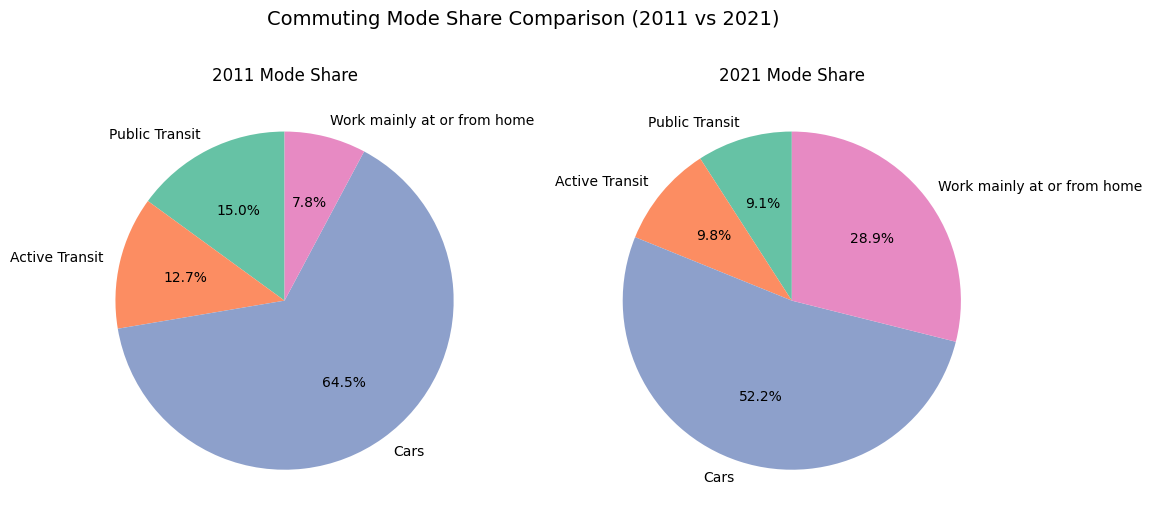

In [ ]:
# ========== pie chart ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]

axes[0].pie(
    tot11, labels=transit_methods_general, autopct="%.1f%%", startangle=90, colors=colors
)
axes[0].set_title("2011 Mode Share")

axes[1].pie(
    tot21, labels=transit_methods_general, autopct="%.1f%%", startangle=90, colors=colors
)
axes[1].set_title("2021 Mode Share")

plt.suptitle("Commuting Mode Share Comparison (2011 vs 2021)", fontsize=14)
plt.show()